In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

## Petroleum Consumption Example

In [2]:
df_petrol = pd.read_csv('https://raw.githubusercontent.com/kgoebber/data_151/main/notebooks/petrol_consumption.csv')

In [3]:
X = df_petrol[['Petrol_tax', 'Average_income', 'Paved_Highways', 'Population_Driver_licence(%)']]
y = df_petrol['Petrol_Consumption']

X_train, X_test, y_train, ytrue = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
scalefit = StandardScaler().fit(X_train)
X_train = scalefit.transform(X_train)
X_test = scalefit.transform(X_test)

In [5]:
pd.DataFrame(X, columns=['Petrol_tax', 'Average_income', 'Paved_Highways', 'Population_Driver_licence(%)']).corr()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%)
Petrol_tax,1.000000,0.012665,-0.522130,-0.288037
Average_income,0.012665,1.000000,0.050163,0.157070
Paved_Highways,-0.522130,0.050163,1.000000,-0.064129
Population_Driver_licence(%),-0.288037,0.157070,-0.064129,1.000000


Let's do a standard regression to set a baseline.

In [6]:
regressor = SGDRegressor()
regressor.fit(X_train, y_train);

y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytrue, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytrue, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrue, y_pred)))
print('R^2: ', metrics.r2_score(ytrue, y_pred))

Mean Absolute Error: 41.74426177942863
Mean Squared Error: 2698.8900969262936
Root Mean Squared Error: 51.95084308195867
R^2:  0.6639476617417293


### PCA Computation
We'll use the function available through Scikit-Learn to computer the principle components of our feature data.

Here we can also give the percentage as a paramter to the PCA function as `pca = PCA(n_components=.95)`. The
`.95` means that we want to include 95% of the variance. Hence PCA will return the number of
components which describe 95% of the variance. However we could also set this to a known 
number of components that we want to keep (e.g., 2), if we knew how many we wanted to keep.

Now let's compute the principal components of the X_train data (our training features matrix), then use the same fit to calculate the PCs of our X_test data.

In [7]:
# Set up PCA function
pca = PCA(n_components=0.95)

# Fit our PCA
pca_fit = pca.fit(X_train) 

# Compute the components on the training data and put into a DataFrame (not strictly needed)
principalComponents = pca_fit.transform(X_train)
pcaDF = pd.DataFrame(data = principalComponents,
                     columns = [f'principal component {i+1}' for i in range(principalComponents.shape[1])])

# Compute the components on the testing data
pcaDF_test = pca_fit.transform(X_test)

Let's look at the correlations between our PCs from our training data - note how none of the principal components are correlated with each other. This is a very important characteristic of PCs!

In [8]:
pcaDF.corr()

,principal component 1,principal component 2,principal component 3,principal component 4
principal component 1,1.000000e+00,2.442789e-16,5.702494e-17,3.795371e-16
principal component 2,2.442789e-16,1.000000e+00,2.535062e-16,2.334363e-16
principal component 3,5.702494e-17,2.535062e-16,1.000000e+00,1.522352e-16
principal component 4,3.795371e-16,2.334363e-16,1.522352e-16,1.000000e+00


Now let's use the PC data to train our regression model...how we'll did we do compared to our base model?

In [9]:
regressor = SGDRegressor()
regressor.fit(pcaDF, y_train);

y_pred = regressor.predict(pcaDF_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytrue, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytrue, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrue, y_pred)))
print('R^2: ', metrics.r2_score(ytrue, y_pred))

Mean Absolute Error: 41.850318972258165
Mean Squared Error: 2711.6102852468766
Root Mean Squared Error: 52.0731244045033
R^2:  0.6623638073146498


/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


Now let's add an ensemble technique to our regression to see if we can get a bit more of improvement.

In [10]:
regressor = BaggingRegressor(base_estimator=SGDRegressor(), n_estimators=1000, max_samples=35, max_features=3)
regressor.fit(X_train, y_train);

y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytrue, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytrue, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrue, y_pred)))
print('R^2: ', metrics.r2_score(ytrue, y_pred))

Mean Absolute Error: 38.26971102312665
Mean Squared Error: 2719.1097876171066
Root Mean Squared Error: 52.1450840215749
R^2:  0.6614300066718748


## Red Wine Prediction Example

Now let's try this with our Red Wine data, which has a few more features and data

In [11]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [12]:
# Use all of our features
features = df.drop(columns=['quality'])
target = df['quality']

# Split our data into training and testing datasets
xtrain, xtest, ytrain, ytrue = train_test_split(features, target, random_state=2)

In [13]:
scalefit = StandardScaler().fit(xtrain)
xtrain_scaled = pd.DataFrame(scalefit.transform(xtrain), columns=features.columns)

In [14]:
xtest_scaled = scalefit.transform(xtest)

In [15]:
pca = PCA(n_components=.95)
pca_fit = pca.fit(xtrain_scaled)
df_pca = pd.DataFrame(pca.transform(xtrain_scaled))
df_pca_test = pd.DataFrame(pca.transform(xtest_scaled))

/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Now let's look at the explained variance ratio of each of our PCs - ideally we want to see an exponential drop off in explained variance.

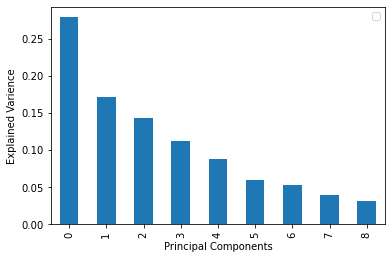

In [16]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.legend('')
plt.xlabel('Principal Components')
plt.ylabel('Explained Varience');

In [17]:
def model_validation(ytrue, y_pred):
    '''Definition for computing and printing a series of Classification metric scores'''
    print(f'Accuracy Score: {metrics.accuracy_score(ytrue, y_pred)}')
    print(f'Precision Score: {metrics.precision_score(ytrue, y_pred, average="macro")}')
    print(f'Recall Score: {metrics.recall_score(ytrue, y_pred, average="macro")}')
    print(f'F1 Score: {metrics.f1_score(ytrue, y_pred, average="macro")}')

Start with a Decision Tree Classification - No PCs.

In [18]:
model = DecisionTreeClassifier(random_state=4)

model.fit(xtrain, ytrain)

y_pred = model.predict(xtest)

model_validation(ytrue, y_pred)

Accuracy Score: 0.585
Precision Score: 0.365003401506469
Recall Score: 0.3802985677985678
F1 Score: 0.3697709553470303


/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now a Decision Tree Classification using PCs as predictors

In [19]:
model = DecisionTreeClassifier(random_state=4)

model.fit(df_pca, ytrain)

y_pred = model.predict(df_pca_test)

model_validation(ytrue, y_pred)

Accuracy Score: 0.585
Precision Score: 0.33367058167260205
Recall Score: 0.33804573804573806
F1 Score: 0.334029619208943


Now a random forecast classification using our PCs as predictors

In [20]:
# Set parameter for max number of features for Random Forest
m = np.int64(np.sqrt(df_pca.shape[1]))

# Set up our Random Forest
random_forest = RandomForestClassifier(max_features=m, max_samples=0.75, oob_score=True, random_state=4)
random_forest.fit(df_pca, ytrain)

y_pred = random_forest.predict(df_pca_test)

model_validation(ytrue, y_pred)
metrics.confusion_matrix(ytrue, y_pred)

Accuracy Score: 0.685
Precision Score: 0.5117426749195474
Recall Score: 0.373704954954955
F1 Score: 0.3962893564739256


/Users/kgoebber/miniconda3/envs/main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0,   0,   0,   1,   0,   0],
       [  0,   0,  10,   3,   0,   0],
       [  0,   0, 111,  33,   4,   0],
       [  0,   0,  45, 135,   5,   0],
       [  0,   0,   3,  18,  27,   0],
       [  0,   0,   0,   2,   2,   1]])

## Titanic Example

One more example that uses the Titanic dataset with a number of different data pre-processing tasks, then use Logistic Regression to set a base prediction scheme with PCs to make a base prediction. Then use a random forest classifier with the PCs to see if we can improve on our model.

In [21]:
# Read in data
titanic_data = pd.read_csv('https://raw.githubusercontent.com/pandas-dev/pandas/master/doc/data/titanic.csv')

In [22]:
# Let's drop the cabin and ticket columns
titanic_data.drop(labels=['Cabin', 'Ticket'], axis=1, inplace=True)

titanic_data["Age"].fillna(titanic_data["Age"].median(), inplace=True)
titanic_data["Embarked"].fillna("S", inplace=True)

encoder_1 = LabelEncoder()

# Fit the encoder on the data
encoder_1.fit(titanic_data["Sex"])

# Transform and replace the training data
titanic_sex_encoded = encoder_1.transform(titanic_data["Sex"])
titanic_data["Sex"] = titanic_sex_encoded

encoder_2 = LabelEncoder()
encoder_2.fit(titanic_data["Embarked"])

titanic_embarked_encoded = encoder_2.transform(titanic_data["Embarked"])
titanic_data["Embarked"] = titanic_embarked_encoded

# Assume the name is going to be useless and drop it
titanic_data.drop("Name", axis=1, inplace=True)

In [23]:
# Remember that the scaler takes arrays
ages_train = np.array(titanic_data["Age"]).reshape(-1, 1)
fares_train = np.array(titanic_data["Fare"]).reshape(-1, 1)

scaler = StandardScaler()

titanic_data["Age"] = scaler.fit_transform(ages_train)
titanic_data["Fare"] = scaler.fit_transform(fares_train)

# Now to select our training and testing data
features = titanic_data.drop(labels=['PassengerId', 'Survived'], axis=1)
labels = titanic_data['Survived']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=27)

In [25]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)
preds = logreg_clf.predict(X_val)

model_validation(y_val, preds)
metrics.confusion_matrix(y_val, preds)

Accuracy Score: 0.8212290502793296
Precision Score: 0.8113026819923372
Recall Score: 0.8031716417910448
F1 Score: 0.8067476383265857


array([[98, 14],
       [18, 49]])

In [26]:
PCA_transform = PCA(n_components=.99)
scalefit = StandardScaler().fit(features)
scaled_features = pd.DataFrame(scalefit.transform(features), columns=features.columns)
PCA_transform.fit(scaled_features)
features_new = PCA_transform.transform(scaled_features)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(features_new, labels, test_size=0.2, random_state=27)

# Set parameter for max number of features for Random Forest
m = np.int64(np.sqrt(X_train.shape[1]))

forest = RandomForestClassifier(max_features=m, max_samples=0.75, random_state=4)
forest.fit(X_train, y_train)
preds = forest.predict(X_val)

model_validation(y_val, preds)
metrics.confusion_matrix(y_val, preds)

Accuracy Score: 0.8212290502793296
Precision Score: 0.8100539811066128
Recall Score: 0.8061700426439233
F1 Score: 0.8079914186108876


array([[97, 15],
       [17, 50]])